# Lab 3


## 1. Obtain the dataset

The dataset (https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats, with Open Data license) contains images of dogs and cats, divided into training (1000 dogs, 1000 cats), validation (500 dogs, 500 cats), and test sets (1000 dogs, 1000 cats). Each image has a resolution of 180×180.


In [3]:
from keras.utils import image_dataset_from_directory
import pathlib

dataset_dir = pathlib.Path("./data/kaggle_dogs_vs_cats_small")

# load the dataset
train_dataset = image_dataset_from_directory(
    dataset_dir / "train",
    image_size=(180, 180),
    batch_size=32,
    label_mode="binary",
    shuffle=True,
)

validation_dataset = image_dataset_from_directory(
    dataset_dir / "validation",
    image_size=(180, 180),
    batch_size=32,
    label_mode="binary",
    shuffle=False,
)

test_dataset = image_dataset_from_directory(
    dataset_dir / "test",
    image_size=(180, 180),
    batch_size=32,
    label_mode="binary",
    shuffle=False,
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## 2. EDA


### 2.1 Class distribution


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class_names = train_dataset.class_names


# Calculate the class distribution for each subset
def get_class_counts(dataset):
  counts = {}
  for _, labels in dataset:
    unique, counts_unique = np.unique(labels, return_counts=True)
    for u, c in zip(unique, counts_unique):
      class_name = class_names[int(u)]
      counts[class_name] = counts.get(class_name, 0) + c
  return counts


train_counts = get_class_counts(train_dataset)
validation_counts = get_class_counts(validation_dataset)
test_counts = get_class_counts(test_dataset)

counts_df = pd.DataFrame(
    {"Train": train_counts, "Validation": validation_counts, "Test": test_counts},
    index=class_names,
)

print("Class distribution for each subset:")
counts_df

Class distribution for each subset:


Train  Validation  Test
cat   1000         500  1000
dog   1000         500  1000

<Figure size 600x600 with 0 Axes>

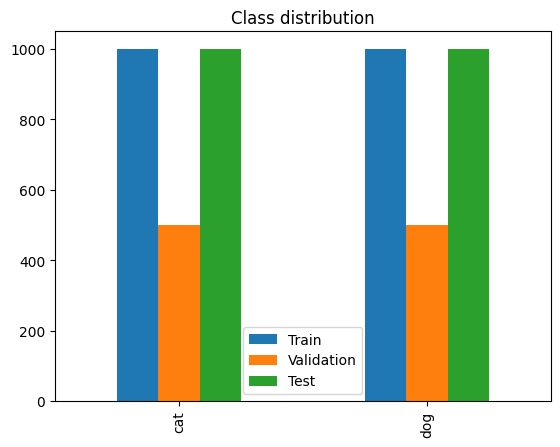

In [5]:
# Plot the class distribution
plt.figure(figsize=(6, 6))
counts_df.plot(kind="bar")
plt.title("Class distribution")
plt.show()

### 2.2 Display sample images


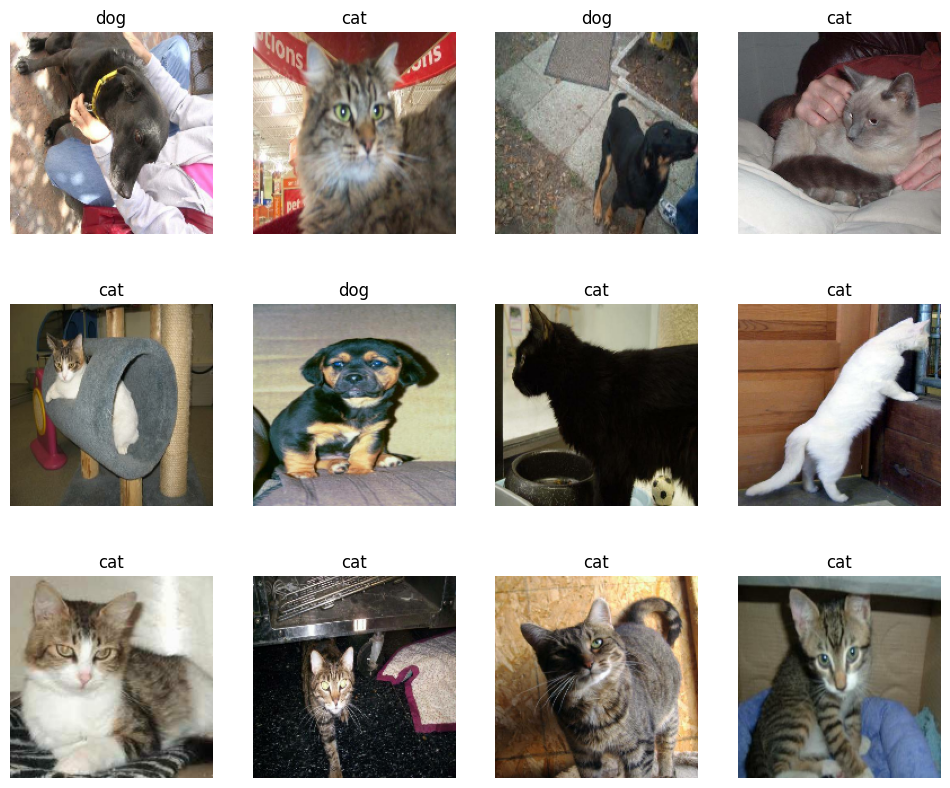

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 10))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

### 2.3 Image size and color channels


In [5]:
# Get the first image from the training dataset
for images, labels in train_dataset.take(1):
  print(f"Image size: {images.shape[1:3]}")
  print(f"Image color channels: {images.shape[3]}")
  break

Image size: (180, 180)
Image color channels: 3


### 2.4 Data augmentation


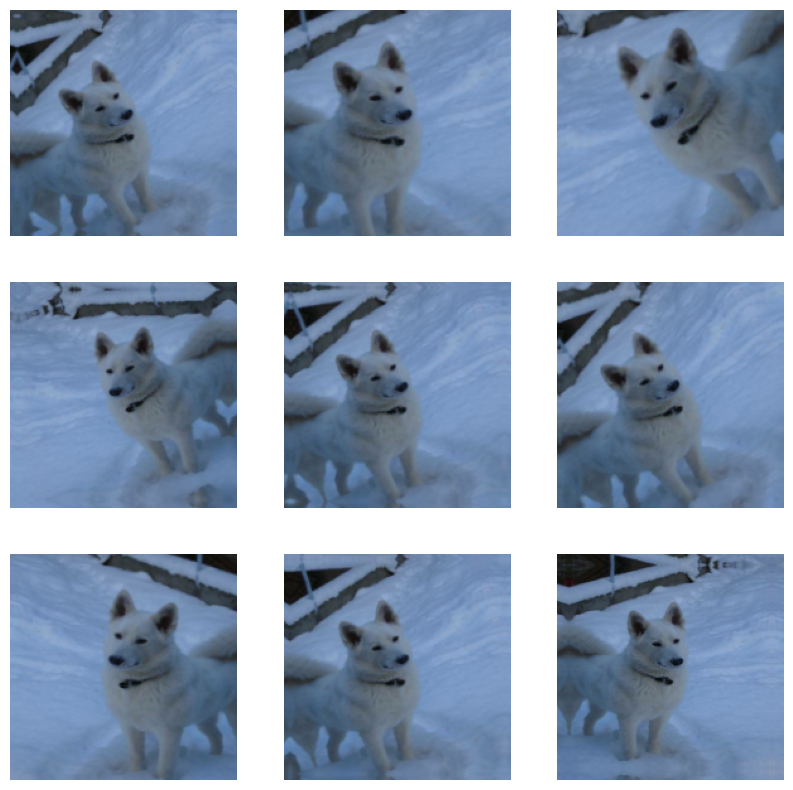

In [6]:
from keras import layers
import keras

# Data augmentation
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.2),
    ]
)

# Display augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## 3. Training vanilla CNN model


Define a vanilla CNN model with data augmentation and dropout.


In [7]:
def create_vanilla_cnn_model():
  inputs = keras.Input(shape=(180, 180, 3))
  x = data_augmentation(inputs)

  x = layers.Rescaling(1.0 / 255)(x)

  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  x = layers.Flatten()(x)

  x = layers.Dense(256, activation="relu")(x)

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

  return model

In [8]:
vanilla_cnn_model = create_vanilla_cnn_model()
vanilla_cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

Train the vanilla CNN model.

In [9]:
vanilla_callbacks = [
  keras.callbacks.ModelCheckpoint(
      filepath="./models/vanilla_cnn_model.h5",
      save_best_only=True,
      monitor="val_loss",
  )
]

vanilla_history = vanilla_cnn_model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=vanilla_callbacks,
)

Epoch 1/100
63/63 [==============================] - 18s 281ms/step - loss: 0.7161 - accuracy: 0.4925 - val_loss: 0.6921 - val_accuracy: 0.5020
Epoch 2/100
63/63 [==============================] - 18s 285ms/step - loss: 0.6967 - accuracy: 0.5015 - val_loss: 0.6923 - val_accuracy: 0.6140
Epoch 3/100
63/63 [==============================] - 19s 296ms/step - loss: 0.6939 - accuracy: 0.5345 - val_loss: 0.6858 - val_accuracy: 0.6150
Epoch 4/100
63/63 [==============================] - 19s 297ms/step - loss: 0.6901 - accuracy: 0.5525 - val_loss: 0.7619 - val_accuracy: 0.5060
Epoch 5/100
63/63 [==============================] - 19s 301ms/step - loss: 0.6810 - accuracy: 0.5810 - val_loss: 0.6543 - val_accuracy: 0.6220
Epoch 6/100
63/63 [==============================] - 19s 304ms/step - loss: 0.6742 - accuracy: 0.6220 - val_loss: 0.6901 - val_accuracy: 0.5310
Epoch 7/100
63/63 [==============================] - 19s 300ms/step - loss: 0.6567 - accuracy: 0.6330 - val_loss: 0.6219 - val_accuracy:

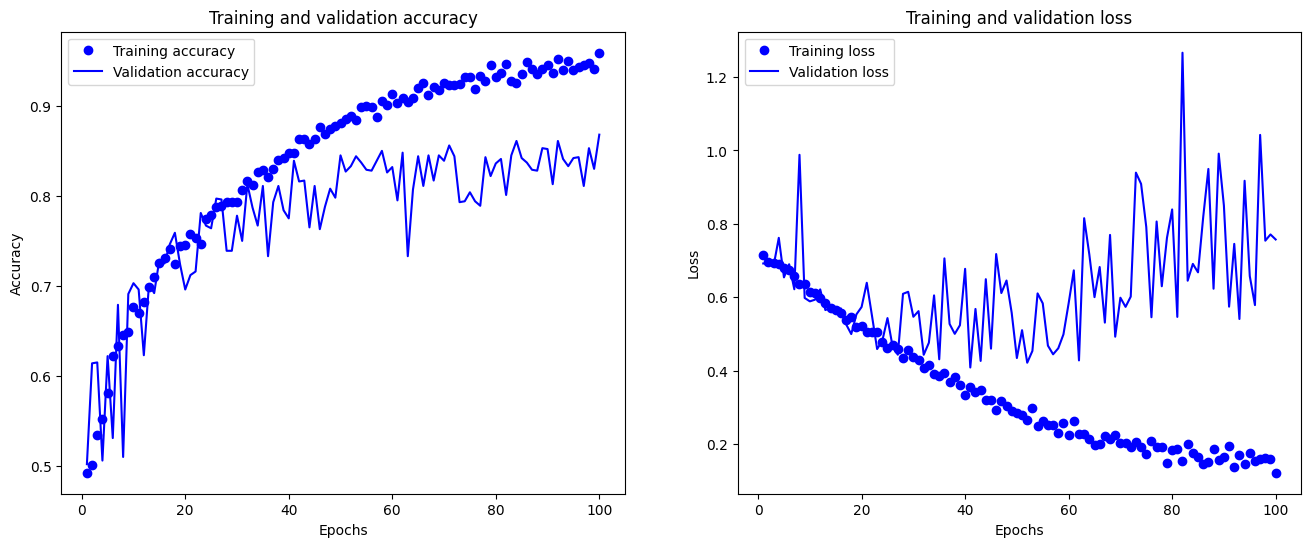

In [10]:
def plot_history(history):
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs_range = range(1, len(accuracy) + 1)

  # accuracy
  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, accuracy, "bo", label="Training accuracy")
  plt.plot(epochs_range, val_accuracy, "b", label="Validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training and validation accuracy")
  plt.legend(loc="upper left")

  # loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, "bo", label="Training loss")
  plt.plot(epochs_range, val_loss, "b", label="Validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training and validation loss")
  plt.legend(loc="upper left")

  plt.show()


plot_history(vanilla_history)

## 4. Fine-tuning VGG16 model


Instantiate the VGG16 model with pre-trained ImageNet weights, remove the top layers.


In [12]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Define a new model using VGG16 as the base, freezing all layers except the top four layers, and add a custom head for fine-tuning. Additionally, use data augmentation.


In [13]:
def create_finetuned_model(conv_base):
  # Freeze all layers until the fourth from the last.
  conv_base.trainable = True
  for layer in conv_base.layers[:-4]:
    layer.trainable = False

  inputs = keras.Input(shape=(180, 180, 3))
  x = data_augmentation(inputs)
  x = keras.applications.vgg16.preprocess_input(x)
  x = conv_base(x)

  x = layers.Flatten()(x)
  x = layers.Dense(256, activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                metrics=["accuracy"])

  return model

In [14]:
finetuned_model = create_finetuned_model(conv_base)
finetuned_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                           

Train the fine-tuned VGG16 model.

In [15]:
finetuned_callbacks = [
  keras.callbacks.ModelCheckpoint(
      filepath="./models/finetuned_vgg16_model.h5",
      save_best_only=True,
      monitor="val_loss",
  )
]

finetuned_history = finetuned_model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=finetuned_callbacks,
)

Epoch 1/50
63/63 [==============================] - 61s 958ms/step - loss: 3.1977 - accuracy: 0.6955 - val_loss: 0.5484 - val_accuracy: 0.8990
Epoch 2/50
63/63 [==============================] - 60s 963ms/step - loss: 1.1677 - accuracy: 0.8155 - val_loss: 0.2910 - val_accuracy: 0.9350
Epoch 3/50
63/63 [==============================] - 60s 963ms/step - loss: 0.6291 - accuracy: 0.8500 - val_loss: 0.1908 - val_accuracy: 0.9470
Epoch 4/50
63/63 [==============================] - 61s 974ms/step - loss: 0.3858 - accuracy: 0.8930 - val_loss: 0.1387 - val_accuracy: 0.9540
Epoch 5/50
63/63 [==============================] - 63s 996ms/step - loss: 0.2866 - accuracy: 0.9095 - val_loss: 0.1301 - val_accuracy: 0.9630
Epoch 6/50
63/63 [==============================] - 62s 982ms/step - loss: 0.2465 - accuracy: 0.9255 - val_loss: 0.1038 - val_accuracy: 0.9710
Epoch 7/50
63/63 [==============================] - 60s 956ms/step - loss: 0.1903 - accuracy: 0.9345 - val_loss: 0.0963 - val_accuracy: 0.9720

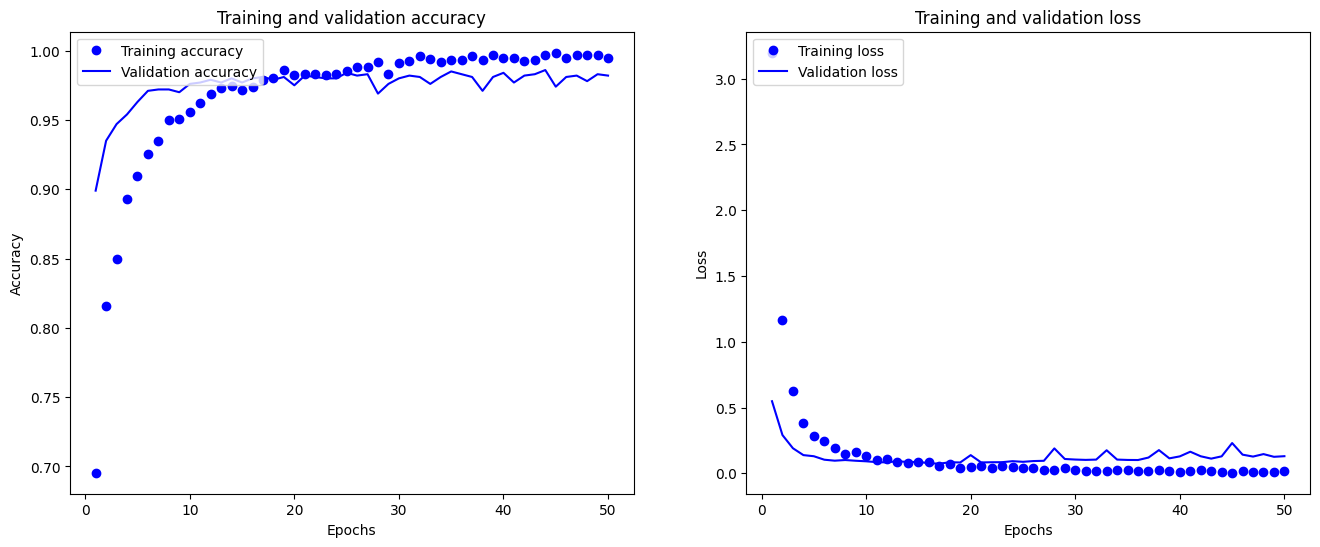

In [16]:
plot_history(finetuned_history)

## 5. Evaluate the models


Define functions to evaluate the models and display the results.

In [31]:
import keras
from sklearn.metrics import classification_report, precision_recall_curve, auc
import tensorflow as tf


def get_predictions(model, dataset):
  y_true_all = []
  y_pred_all = []
  y_pred_bin_all = []

  for images, y_true in dataset:
    y_pred = model.predict(images)
    y_pred_bin = (y_pred > 0.5)

    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)
    y_pred_bin_all.extend(y_pred_bin)

  return (np.array(y_true_all).flatten().astype(int),
          np.array(y_pred_all).flatten(),
          np.array(y_pred_bin_all).flatten().astype(int))


def calc_confusion_matrix(y_true, y_pred_bin):
  cm = tf.math.confusion_matrix(y_true, y_pred_bin)
  TP = cm[1][1]
  TN = cm[0][0]
  FP = cm[0][1]
  FN = cm[1][0]

  return TP, TN, FP, FN


def plot_precision_recall_curve(y_true, y_pred):
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  pr_auc = auc(recall, precision)

  plt.figure(figsize=(8, 6))
  plt.plot(recall, precision, marker=".", label=f"AUC: {pr_auc:.3f}")
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("Precision-Recall Curve")
  plt.legend(loc='lower left')
  plt.grid()
  plt.show()


def evaluate_model(model_path, dataset):
  model = keras.models.load_model(model_path)

  y_true, y_pred, y_pred_bin = get_predictions(model, dataset)
  TP, TN, FP, FN = calc_confusion_matrix(y_true, y_pred_bin)

  result = f"\n{classification_report(y_true, y_pred_bin, target_names=class_names)}\n"

  result += f"\nConfusion matrix:\n"
  result += f"{'-' * 25}\n"
  result += f"| TP: {TP:5} | FP: {FP:5} |\n"
  result += f"{'-' * 25}\n"
  result += f"| FN: {FN:5} | TN: {TN:5} |\n"
  result += f"{'-' * 25}"

  return result, y_true, y_pred, y_pred_bin


def show_misclassified_images(y_true, y_pred_bin, dataset, max_num=5):
  errors = np.where(y_true != y_pred_bin)[0]

  max_cols = 5
  num_images = min(len(errors), max_num)
  rows = (num_images + max_cols - 1) // max_cols

  selected_errors = np.random.choice(errors, num_images, replace=False)

  fig, axes = plt.subplots(rows, max_cols, figsize=(15, 4 * rows))
  axes = axes.flatten()

  for i, idx in enumerate(selected_errors):
    image, label = list(dataset.unbatch().as_numpy_iterator())[idx]
    prediction = class_names[y_pred_bin[idx]]

    axes[i].imshow(image.astype("uint8"))
    axes[i].set_title(f"True: {class_names[int(label)]}     Pred: {prediction}")
    axes[i].axis("off")

  # Hide the remaining axes
  for i in range(num_images, len(axes)):
    axes[i].axis("off")

  plt.suptitle("Misclassified images")
  plt.tight_layout()
  plt.show()

### 5.1 Vanilla CNN model

In [8]:
# Evaluate the vanilla CNN model
(vanilla_report,
 y_true_vanilla,
 y_pred_vanilla,
 y_pred_bin_vanilla) = evaluate_model("./models/vanilla_cnn_model.h5", test_dataset)

1/1 [==============================] - 0s 65ms/step


In [23]:
print(f"Vanilla CNN model:\n{vanilla_report}")

Vanilla CNN model:

              precision    recall  f1-score   support

         cat       0.83      0.81      0.82      1000
         dog       0.82      0.83      0.82      1000

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000


Confusion matrix:
-------------------------
| TP:   831 | FP:   185 |
-------------------------
| FN:   169 | TN:   815 |
-------------------------


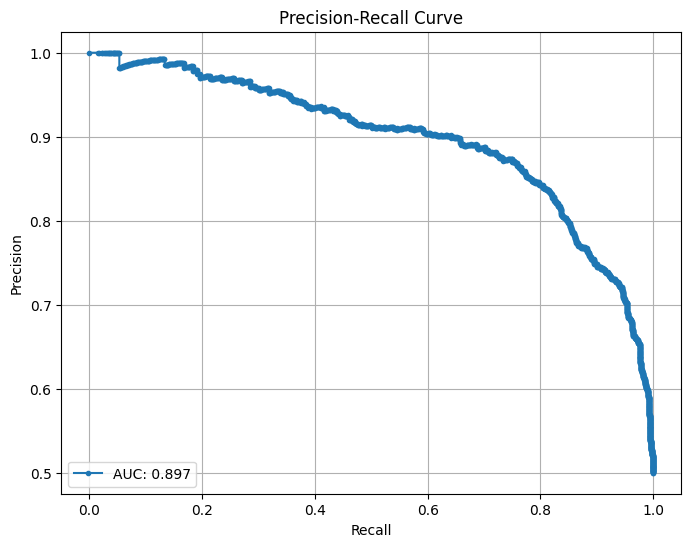

In [32]:
# plot the precision-recall curve
plot_precision_recall_curve(y_true_vanilla, y_pred_vanilla)

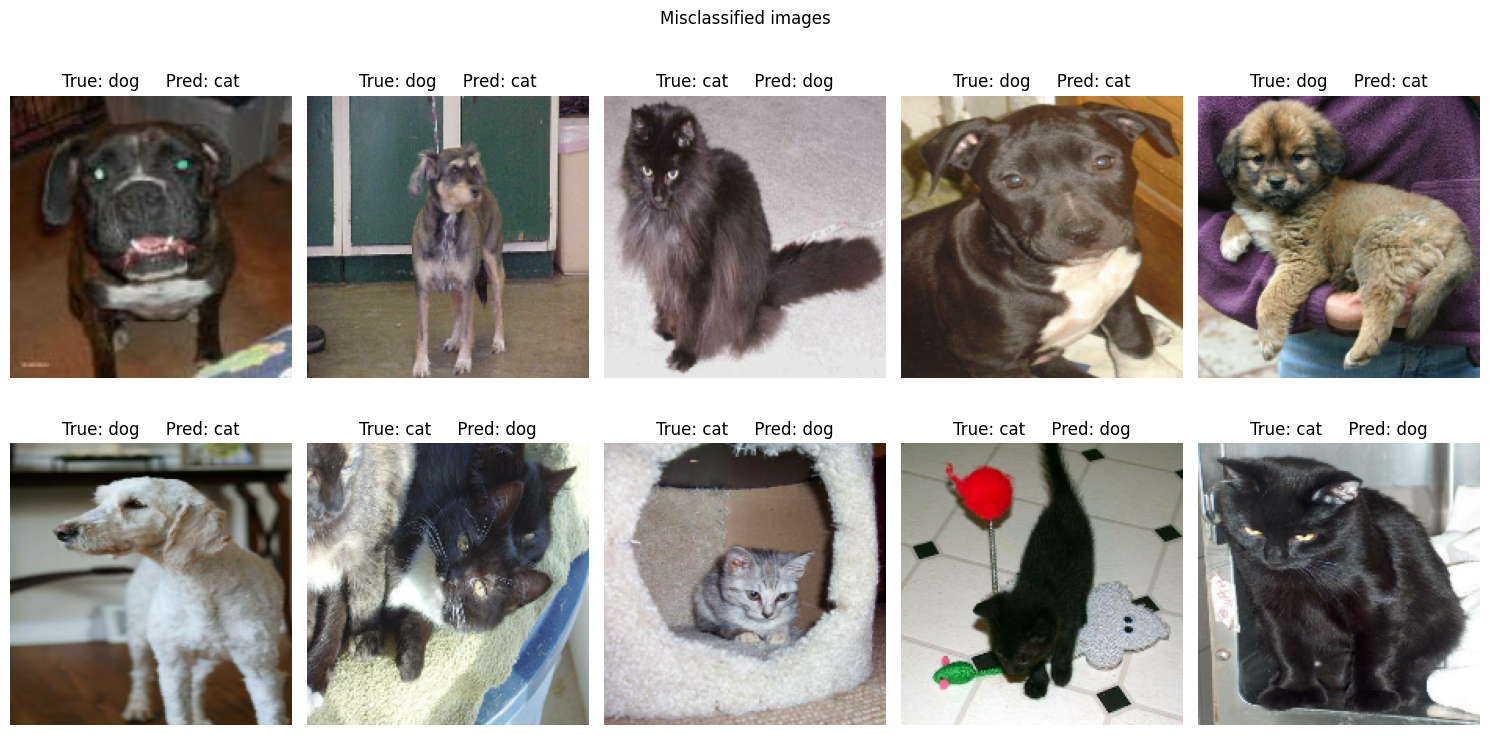

In [13]:
#　Show misclassified images
show_misclassified_images(y_true_vanilla, y_pred_bin_vanilla, test_dataset, 10)

### 5.2 Fine-tuned VGG16 model

In [14]:
# Evaluate the fine-tuned VGG 16 model
(finetuned_report,
 y_true_finetuned,
 y_pred_finetuned,
 y_pred_bin_finetuned) = evaluate_model("./models/finetuned_vgg16_model.h5", test_dataset)

1/1 [==============================] - 0s 290ms/step


In [15]:
print(f"Fine-tuned VGG16 model:\n{finetuned_report}")

Fine-tuned VGG16 model:

              precision    recall  f1-score   support

         cat       0.97      0.98      0.98      1000
         dog       0.98      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


Confusion matrix:
-------------------------
| TP:   967 | FP:    16 |
-------------------------
| FN:    33 | TN:   984 |
-------------------------


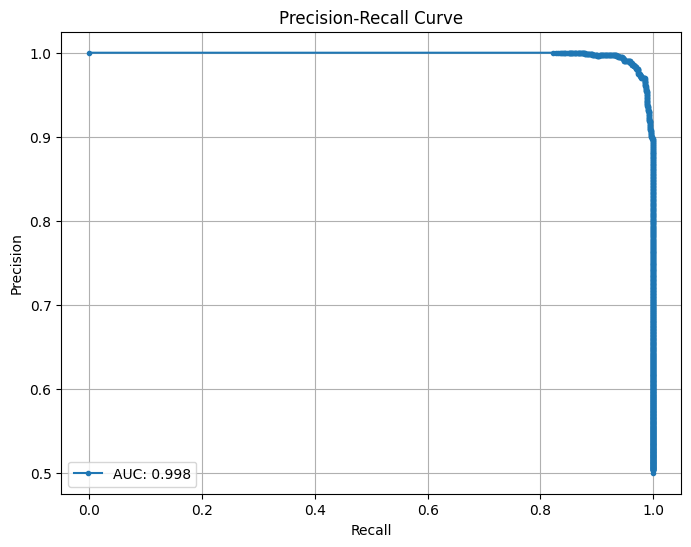

In [33]:
# plot the precision-recall curve
plot_precision_recall_curve(y_true_finetuned, y_pred_finetuned)

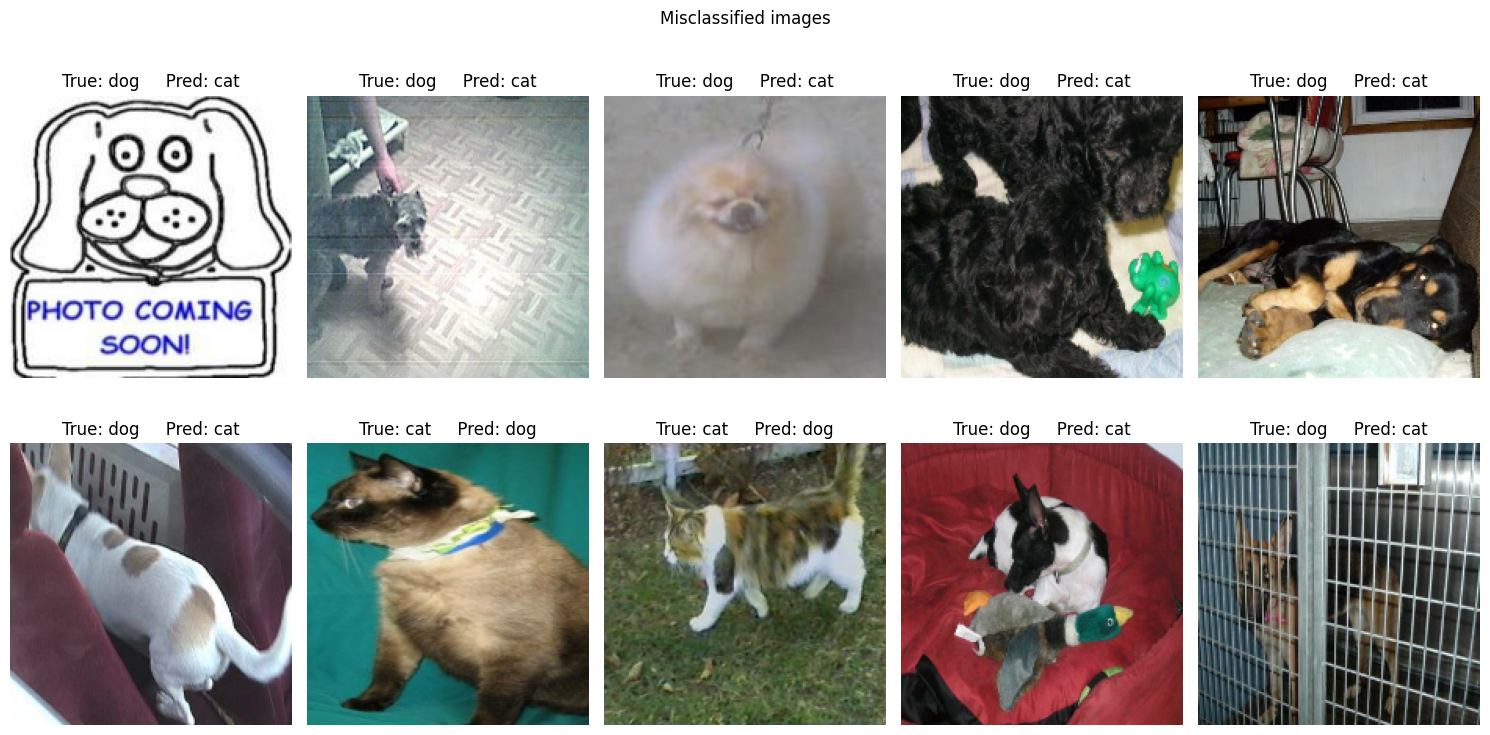

In [20]:
# Show misclassified images
show_misclassified_images(y_true_finetuned, y_pred_bin_finetuned, test_dataset, 10)

## 6. Conclusion


In this lab, I trained two different models for the cat and dog classification task:

1. Vanilla Convolutional Neural Network (CNN):
  - **Advantages**: Simple structure and shorter training time.
  - **Disadvantages**: Lower performance in terms of accuracy and other evaluation metrics compared to the fine-tuned VGG16 model, and more prone to overfitting. Overfitting occurred around the 35th epoch. The precision-recall curve shows a relatively smaller area under the curve (AUC = 0.897), indicating that the model struggles with maintaining high precision and recall.

2. Fine-tuned pre-trained VGG16 model:
  - **Advantages**: Utilized the feature extraction capabilities of the pre-trained model, achieving better performance in accuracy, precision, recall, and F1 score. After fine-tuning, the model demonstrated better generalization on the test set. The precision-recall curve for this model highlights its superior performance, with an almost perfect AUC of 0.998, reflecting its excellent ability to distinguish between classes consistently.

  - **Disadvantages**: Longer training time and higher computational resource requirements, with the training time per epoch being three times that of the vanilla CNN.

To further improve the model's performance, the following measures can be taken:

1. Optimize hyperparameters such as learning rate, batch size, and optimizer.
2. Experiment with more complex pre-trained models (e.g., ResNet) for fine-tuning or use ensemble learning by combining multiple models.
3. Increase the size of the dataset to enhance generalization and reduce overfitting risks.

Overall, the fine-tuned VGG16 model performed exceptionally well in this task, demonstrating the powerful capabilities in image classification, particularly when fine-tuned with domain-specific data.